# "FileDB": Querying Millennium Run particles
### Calculate density profiles (in SQL)<br/>Fit to NFW profile<br/>Show fits<br/>Plot parameters

In [1]:
with open('/home/idies/keystone.token', 'r') as f:
    token = f.read().rstrip('\n')
import sys
sys.argv.append("--ident="+token)
token

'da9b31e4a0f34421a129f82e0ee59ebb'

In [2]:
# Import necessary libraries.
# "BOILERPLATE"
import SciServer.CasJobs
import SciServer.Keystone
import SciServer.SciDrive
import os
import pandas
import tables
import matplotlib.pyplot as plt
import pylab as pl
import numpy
import math
# load library for fitting
from scipy.optimize import curve_fit

In [3]:
# define fitting function from Navarro, Frenk & White 1995
# we will fit log of rdensity profile
def nfw(radius, rho0, Rs):
    return numpy.log10(rho0*(1/((radius/Rs)*(1+radius/Rs)**2)))

In [4]:
# define fitting function from Navarro, Frenk & White 1995
# we will fit log of rdensity profile
def hern(radius, M, a):
    return numpy.log10(0.5*M*a/((radius)*(a+radius)**3)/math.pi)

## SQL
<pre style="font-size:18px;">
with ps as (
select h.haloId,p.x-hh.x as x,p.y-hh.y as y,p.z-hh.z as z, hh.np
from mydb.strathalosample h
   inner join mpahalotrees..mr hh
  on hh.haloid=h.haloid 
  and h.rank <= 8
  and h.npbin between 15 and 27
      <b>cross apply dbo.MillenniumParticles(hh.snapnum,
          dbo.Sphere::New(hh.x,hh.y,hh.z,3*hh.halfmassradius).ToString())</b> p
),
rs as (
select haloid,sqrt(x*x+y*y+z*z) as r, np
from ps
)
select haloid, max(np) as np,
 power(convert(real,10 ),.1*floor(log10(r)/.1)) as r1
  , power(convert(real, 10),.1*(1+floor(log10(r)/.1))) as r2, count(*) as num
  from rs where r > 0
  group by haloid, floor(log10(r)/.1)
  order by 1,3
```

In [5]:
# define SQL: query from Millennium halo merger trees tab 
# find halos with mass in given range
#
# Sample defined by:
#------------------------------------------------
#with h as (
#  select haloid,  np, floor(log10(np)/.2) as npbin
#    ,   rank() over(partition by floor(log10(np)/.2) order by newid()) as rank
#  from mpahalotrees..mr 
#  where snapnum=63 and haloid=firsthaloinfofgroupid
#)
#select * 
#into MyDB.StratHaloSample
#from h where rank <= 10
#------------------------------------------------
query="""
with ps as (
select h.haloId,p.x-hh.x as x,p.y-hh.y as y,p.z-hh.z as z, hh.np
from mydb.strathalosample h
   inner join mpahalotrees..mr hh
  on hh.haloid=h.haloid 
  and h.rank <= 8
  and h.npbin between 15 and 27
      cross apply dbo.MillenniumParticles(hh.snapnum,
      dbo.Sphere::New(hh.x,hh.y,hh.z,3*hh.halfmassradius).ToString()) p
),
rs as (
select haloid,sqrt(x*x+y*y+z*z) as r, np
from ps
)
select haloid, max(np) as np,
 power(convert(real,10 ),.1*floor(log10(r)/.1)) as r1
  , power(convert(real, 10),.1*(1+floor(log10(r)/.1))) as r2, count(*) as num
  from rs where r > 0
  group by haloid, floor(log10(r)/.1)
  order by 1,3
"""
# query CasJobs table. Using SimulationDB as context
queryResponse = SciServer.CasJobs.executeQuery(query, "SimulationDB")

# parse results into py DataFrame for further in memory processing
profs = pandas.read_csv(queryResponse,index_col=None)
print("Found "+str(profs.count()[0])+" rows")

executeQuery POST response:  200 OK
Found 2735 rows


In [9]:
profs
haloIds=numpy.unique(profs['haloid'])

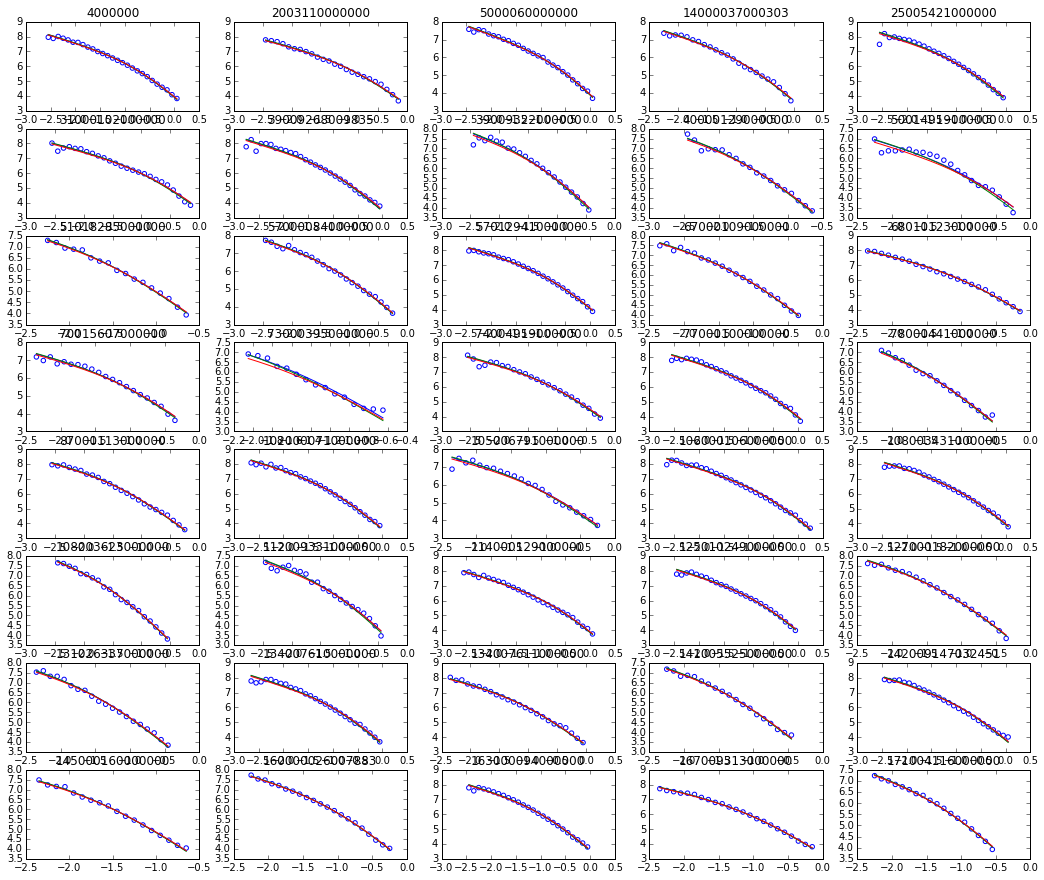

In [10]:
plt.figure(figsize=(18, 15))
plt.xlabel('log10(radius/Mpc)')
plt.ylabel('density in #/Mpc^3')
plt.title('Density Profile')

subPlotNum = 1

# restrict to small sample for demo purposes
nmax=40
count=0
params=[]
cov=[]
for haloId in haloIds:
    df=profs.loc[(profs.haloid ==haloId), ['haloid','np','r1', 'r2', 'num']]
    hs=numpy.array(df['haloid'].tolist())
    n1=3
    n2=len(hs)-1
    np=numpy.array(df['np'].tolist())[0]
    r1=numpy.array(df['r1'].tolist())[n1:n2]
    r2=numpy.array(df['r2'].tolist())[n1:n2]
    num=numpy.array(df['num'].tolist())[n1:n2]
    r=numpy.sqrt(r1*r2)
    v=4*math.pi*(r2**3-r1**3)/3
    d = num/v
    ld = numpy.log10(d)
    lr=numpy.log10(r)
    
    fitFunc=nfw
    p0=[np, 0.05]
    

#    fitFunc=hern
#    p0=[np, 0.05]

    fitParams, fitCovariances = curve_fit(fitFunc, r,ld, p0=p0)
    params.append(fitParams)
    cov.append(fitCovariances)
    
# plot density profiles as open dots and fit +/- 1 sigma as lines     
    plt.subplot(8,5,subPlotNum)
    subPlotNum += 1
    plt.scatter(lr, ld,facecolors='none', edgecolors='b')
    plt.plot(lr, (fitFunc(r, fitParams[0], fitParams[1])),
             lr, (fitFunc(r, fitParams[0] + numpy.sqrt(fitCovariances[0,0]), fitParams[1]- numpy.sqrt(fitCovariances[1,1]))),
             lr, (fitFunc(r, fitParams[0] - numpy.sqrt(fitCovariances[0,0]), fitParams[1] + numpy.sqrt(fitCovariances[1,1]))))
    plt.title(str(haloId))

    
    count+=1
    if(count >= nmax):
        break
    
plt.show()


In [11]:
def straight(lmass, a, b):
    return a*lmass+b

In [38]:
p1,p2=zip(*params)

p0=[2,0]
ab, errab = curve_fit(straight, numpy.log10(p1), numpy.log10(p2),p0=p0)
xx=[min(numpy.log10(p1)), max(numpy.log10(p1))]
yy=[straight(min(numpy.log10(p1)),ab[0],ab[1]), straight(max(numpy.log10(p1)),ab[0],ab[1])]
ab

array([-0.63735383,  3.04564836])

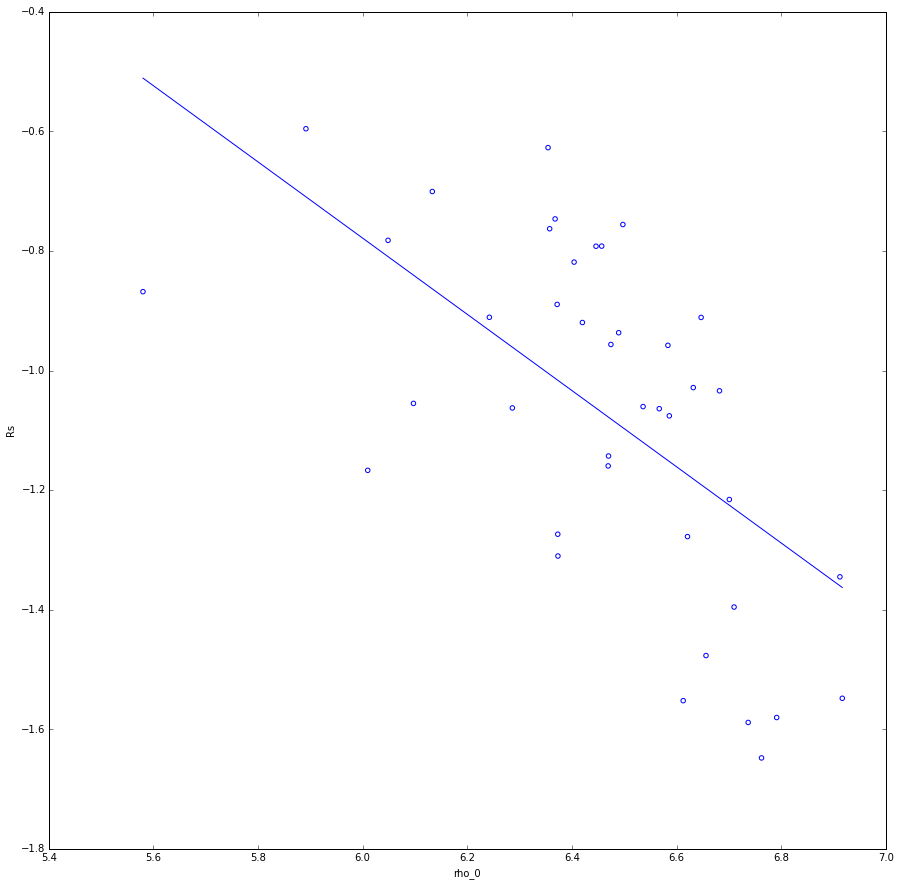

In [42]:
plt.figure(figsize=(15, 15))
plt.xlabel('rho_0')
plt.ylabel('Rs')
plt.scatter(numpy.log10(p1), numpy.log10(p2),facecolors='none', edgecolors='b')
plt.plot(xx,yy)
plt.show()

# IGNORE

In [15]:
from pylab import figure, show, rand
from matplotlib.patches import Ellipse


ells = [errorEllipse(params[i],cov[i])
        for i in range(len(params))]

fig = figure()
ax = fig.add_subplot(111, aspect='equal')
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(rand())
    e.set_facecolor(rand(3))

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

show()

TypeError: errorEllipse() missing 2 required positional arguments: 'edge' and 'face'

In [13]:
def errorEllipse(pos,P,edge,face): 
    U, s , Vh = svd(P) 
    orient = math.atan2(U[1,0],U[0,0])*180/pi 
    ellipsePlot = Ellipse(xy=pos, width=2.0*math.sqrt(s[0]), height=2.0*math.sqrt(s[1]), angle=orient,facecolor=face, edgecolor=edge) 
    return ellipsePlot; 